In [4]:

import logging
import gin
gin.clear_config()

import os
import accelerate
import traceback
from internal.configs import Config
from internal import configs
from internal import models
import json

from typing import Any, Dict

import numpy as np
import torch

from internal import camera_utils

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler(), logging.FileHandler("nerf_server.log")],
)
logger = logging.getLogger(__name__)

nerf_model = None
config = None
accelerator = None
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
def load_config(config_path, bindings=None):
    if bindings is None:
        bindings = []
    
    gin.parse_config_files_and_bindings(
        [config_path], bindings, skip_unknown=True)
    config = Config()

        
    return config

In [12]:
gin.clear_config()
config = load_config("configs/train.gin")

In [10]:
from internal import checkpoints


def load_nerf_model(checkpoint_dir: str) -> bool:
    """Load a NeRF model from a checkpoint directory"""
    global nerf_model, config, accelerator

    try:
        logger.info(f"Loading NeRF model from checkpoint: {checkpoint_dir}")

        # Check if path exists
        if not os.path.exists(checkpoint_dir):
            logger.error(f"Checkpoint directory not found: {checkpoint_dir}")
            return False

        # Load dataset size from transform.json
        transform_json_path = os.path.join(checkpoint_dir, "..", "transform.json")
        dataset_size = 57  # Default fallback value
        
        with open(transform_json_path, 'r') as f:
            transform_data = json.load(f)
            dataset_size = transform_data.get('dataset_size', 57)
            logger.info(f"Loaded dataset size from transform.json: {dataset_size}")

        # Restore the checkpoint
        from accelerate import Accelerator
        accelerator = Accelerator()
        
        # Set dataset info with loaded size
        dataset_info_for_model = {
            'size': dataset_size,
        }
        
        # Create and prepare model
        nerf_model = models.Model(config=config, dataset_info=dataset_info_for_model)
        nerf_model.eval()
        nerf_model = accelerator.prepare(nerf_model)
        
        # Restore checkpoint
        step = checkpoints.restore_checkpoint(checkpoint_dir, accelerator, logger, strict=config.load_state_dict_strict)
        logger.info(f"Successfully loaded NeRF model from checkpoint at step {step}")

        return True
    except Exception as e:
        logger.error(f"Error loading NeRF model: {str(e)}")
        logger.error(traceback.format_exc())
        return False

In [ ]:
def pad_poses(p):
    """Pad [..., 3, 4] pose matrices with a homogeneous bottom row [0,0,0,1]."""
    bottom = np.broadcast_to([0, 0, 0, 1.], p[..., :1, :4].shape)
    return np.concatenate([p[..., :3, :4], bottom], axis=-2)

def create_rays_from_camera_params(params: Dict[str, Any]) -> Dict[str, torch.Tensor]:
    """Create rays from the provided camera parameters, similar to generate_ray_batch"""
    width = params["width"]
    height = params["height"]
    transform = np.array(params['transform'], dtype=np.float32)
    scaling_factor = params['scaling_factor']
    
    camtoworld_list = params["camtoworld"]                                                       
    camtoworld = np.array(camtoworld_list, dtype=np.float32)

    # Ensure it's 4x4
    if camtoworld.shape == (3, 4):
        camtoworld = pad_poses(camtoworld)
    elif camtoworld.shape == (4, 4):
        raise ValueError(f"camtoworld must be 3x4 or 4x4 matrix, got {camtoworld.shape}")
    
    # Switch from COLMAP (right, down, fwd) to NeRF (right, up, back) frame.
    # camtoworld = camtoworld @ np.diag([1, -1, -1, 1])

    camtoworld = transform @ camtoworld
    camtoworld[:3, 3] *= scaling_factor
    
    # Ensure it's 3x4
    camtoworld = camtoworld[:3, :]
    
    focal_x = params["focal_x"]
    focal_y = params["focal_y"]
    cx = params["cx"]
    cy = params["cy"]
    image_downsample_fac = params["image_downsample_fac"]
    # # Create inverse intrinsic matrix (pixel to camera)
    pixtocam = np.linalg.inv(camera_utils.intrinsic_matrix(focal_x, focal_y, cx, cy))
    pixtocam = np.array(pixtocam, dtype=np.float32)
    pixtocam = pixtocam @ np.diag([image_downsample_fac, image_downsample_fac, 1.])
    pixtocam = np.array(pixtocam, dtype=np.float32)    
    
    # Generate pixel coordinates - output shape is (height, width)
    pix_x_int, pix_y_int = camera_utils.pixel_coordinates(width, height)

    cam_idx = 0  # Since we're just using one camera
    
    # Prepare camera parameters
    cameras = (
        pixtocam, 
        camtoworld,
        None,  # distortion_params
        None   # pixtocam_ndc
    )
    
    # Prepare pixel parameters
    near = config.near if config else 0.2
    far = config.far if config else 1000.0
    near = 0.2
    far = 2
    
    broadcast_scalar = lambda x: np.broadcast_to(x, pix_x_int.shape)[..., None]
    
    ray_kwargs = {
        'lossmult': broadcast_scalar(1.),
        'near': broadcast_scalar(near),
        'far': broadcast_scalar(far),
        'cam_idx': broadcast_scalar(cam_idx),
    }
    
    pixels = {
        'pix_x_int': pix_x_int, 
        'pix_y_int': pix_y_int, 
        **ray_kwargs
    }
    
    # Use camera_utils to cast rays
    batch = camera_utils.cast_ray_batch(cameras, pixels, camera_utils.ProjectionType.PERSPECTIVE)
    
    # Add cam_dirs (needed by model) - FIX: broadcast to the right shape
    cam_dirs = -camtoworld[:3, 2]  # Extract camera forward direction
    batch['cam_dirs'] = np.broadcast_to(cam_dirs, pix_x_int.shape + (3,))
    
    # Add normalized pixel coordinates
    pix_x_float = (pix_x_int.astype(np.float32) + 0.5) / width
    pix_y_float = (pix_y_int.astype(np.float32) + 0.5) / height
    batch['pix_xy'] = np.stack([pix_x_float, pix_y_float], axis=-1)
    
    # Convert to torch tensors
    batch = {k: torch.from_numpy(v.copy()).float() if v is not None else None for k, v in batch.items()}

    for k, v in batch.items():
        if v is not None:
            logger.debug(f"Ray batch tensor '{k}' has shape {v.shape}")
    
    return batch

In [7]:
from torch.utils._pytree import tree_map

def render_image_from_rays(ray_batch, height, width, config, nerf_model, accelerator):
    """A simpler wrapper around models.render_image that adds extra debugging"""
    # Move batch to device 
    ray_batch = tree_map(lambda x: x.to(accelerator.device) if x is not None else None, ray_batch)
    
    # Call render_image with the flattened batch
    with torch.no_grad():
        rendering = models.render_image(
            nerf_model, 
            accelerator, 
            ray_batch,
            rand=False,
            train_frac=1.0,
            config=config,
            verbose=True
        )
    
    return rendering

In [13]:
load_nerf_model("exp/test_apr29_1_opaque/checkpoints")

2025-05-25 12:48:16,165 - __main__ - INFO - Loading NeRF model from checkpoint: exp/test_apr29_1_opaque/checkpoints
2025-05-25 12:48:16,166 - __main__ - INFO - Loaded dataset size from transform.json: 57
2025-05-25 12:48:16,871 - __main__ - INFO - Resuming from checkpoint exp/test_apr29_1_opaque/checkpoints/025000
2025-05-25 12:48:16,872 - accelerate.accelerator - INFO - Loading states from exp/test_apr29_1_opaque/checkpoints/025000
2025-05-25 12:48:17,241 - accelerate.checkpointing - INFO - All model weights loaded successfully
2025-05-25 12:48:17,242 - accelerate.checkpointing - INFO - All optimizer states loaded successfully
2025-05-25 12:48:17,243 - accelerate.checkpointing - INFO - All scheduler states loaded successfully
2025-05-25 12:48:17,244 - accelerate.checkpointing - INFO - All dataloader sampler states loaded successfully
2025-05-25 12:48:17,250 - accelerate.checkpointing - INFO - All random states loaded successfully
2025-05-25 12:48:17,252 - accelerate.accelerator - INFO

True

In [14]:
camtoworld = [[ 0.92515859,  0.22006658, -0.30927703,  1.41879892],
 [ 0.14209328, -0.95632995, -0.25542617, -2.34771575],
 [-0.35198165,  0.19236353, -0.91602685, -1.21624539]]        

transform = [
    [
      0.33949030538545366,
      -0.9401101949977007,
      -0.03064561650018798,
      0.40502799888040486
    ],
    [
      -0.7538602695514978,
      -0.29142801394611134,
      0.588867053484204,
      0.15589131990937016
    ],
    [
      -0.5625309116315604,
      -0.17681214310338098,
      -0.8076487104615194,
      0.45412532856495935
    ],
    [
      0.0,
      0.0,
      0.0,
      1.0
    ]
  ]

scaling_factor =  0.12106293726660113
fx, fy, cx, cy = 1773.294491, 1773.544729, 1502.500000, 2032.500000
image_downsample_fac = 4

request_data = {'camera': {'camtoworld': camtoworld, 'transform': transform, 'scaling_factor': scaling_factor,  'focal': 1773.2944910750875, 'width': 751, 'height': 1016, 'focal_x': fx, 'focal_y': fy, 'cx': cx, 'cy': cy, 'image_downsample_fac': image_downsample_fac}}

In [20]:
data = request_data
logger.debug(f"Request data: {data}")

camera_params = data.get("camera")

# Extract width and height for later use
width = camera_params["width"]
height = camera_params["height"]

# Create rays from camera parameters
logger.info("Creating rays from camera parameters")
ray_batch = create_rays_from_camera_params(camera_params)

# Render the view
logger.info("Rendering view")
print(config)
rendering = render_image_from_rays(ray_batch, height, width, config, nerf_model, accelerator)

# Convert to numpy
rendering = tree_map(lambda x: x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x, rendering)

# Process results
result = {}
if 'rgb' in rendering:
    result["image"] = rendering['rgb']

if 'distance_mean' in rendering:
    result["depth_mean"] = rendering['distance_mean']

if 'distance_median' in rendering:
    result["depth_median"] = rendering['distance_median']

if 'normals' in rendering:
    result["normals"] = rendering['normals']

if 'acc' in rendering:
    result["acc"] = rendering['acc']
    
logger.info("Rendering completed successfully")
print(rendering.keys())



2025-05-25 13:03:39,498 - __main__ - DEBUG - Request data: {'camera': {'camtoworld': [[0.92515859, 0.22006658, -0.30927703, 1.41879892], [0.14209328, -0.95632995, -0.25542617, -2.34771575], [-0.35198165, 0.19236353, -0.91602685, -1.21624539]], 'transform': [[0.33949030538545366, -0.9401101949977007, -0.03064561650018798, 0.40502799888040486], [-0.7538602695514978, -0.29142801394611134, 0.588867053484204, 0.15589131990937016], [-0.5625309116315604, -0.17681214310338098, -0.8076487104615194, 0.45412532856495935], [0.0, 0.0, 0.0, 1.0]], 'scaling_factor': 0.12106293726660113, 'focal': 1773.2944910750875, 'width': 751, 'height': 1016, 'focal_x': 1773.294491, 'focal_y': 1773.544729, 'cx': 1502.5, 'cy': 2032.5, 'image_downsample_fac': 4}}
2025-05-25 13:03:39,501 - __main__ - INFO - Creating rays from camera parameters
2025-05-25 13:03:39,836 - __main__ - DEBUG - Ray batch tensor 'origins' has shape torch.Size([1016, 751, 3])
2025-05-25 13:03:39,838 - __main__ - DEBUG - Ray batch tensor 'direc

[[[6.6577893e-04 4.9212598e-04]
  [1.9973370e-03 4.9212598e-04]
  [3.3288947e-03 4.9212598e-04]
  ...
  [9.9667108e-01 4.9212598e-04]
  [9.9800265e-01 4.9212598e-04]
  [9.9933422e-01 4.9212598e-04]]

 [[6.6577893e-04 1.4763779e-03]
  [1.9973370e-03 1.4763779e-03]
  [3.3288947e-03 1.4763779e-03]
  ...
  [9.9667108e-01 1.4763779e-03]
  [9.9800265e-01 1.4763779e-03]
  [9.9933422e-01 1.4763779e-03]]

 [[6.6577893e-04 2.4606299e-03]
  [1.9973370e-03 2.4606299e-03]
  [3.3288947e-03 2.4606299e-03]
  ...
  [9.9667108e-01 2.4606299e-03]
  [9.9800265e-01 2.4606299e-03]
  [9.9933422e-01 2.4606299e-03]]

 ...

 [[6.6577893e-04 9.9753934e-01]
  [1.9973370e-03 9.9753934e-01]
  [3.3288947e-03 9.9753934e-01]
  ...
  [9.9667108e-01 9.9753934e-01]
  [9.9800265e-01 9.9753934e-01]
  [9.9933422e-01 9.9753934e-01]]

 [[6.6577893e-04 9.9852359e-01]
  [1.9973370e-03 9.9852359e-01]
  [3.3288947e-03 9.9852359e-01]
  ...
  [9.9667108e-01 9.9852359e-01]
  [9.9800265e-01 9.9852359e-01]
  [9.9933422e-01 9.9852359e-

2025-05-25 13:03:44,853 - __main__ - INFO - Rendering completed successfully                                                                                                                                                                                                                                                                                                                     


dict_keys(['rgb', 'depth', 'acc', 'distance_mean', 'distance_percentile_5', 'distance_median', 'distance_percentile_95', 'rgb_affine_mats', 'cam_idx', 'ray_sdist', 'ray_weights', 'ray_rgbs'])


2025-05-25 15:14:31,712 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fb869e75970>
2025-05-25 15:14:31,737 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fb869e89fa0>


RGB shape: (1016, 751, 3)
Acc shape: (1016, 751)
Depth median shape: (1016, 751)


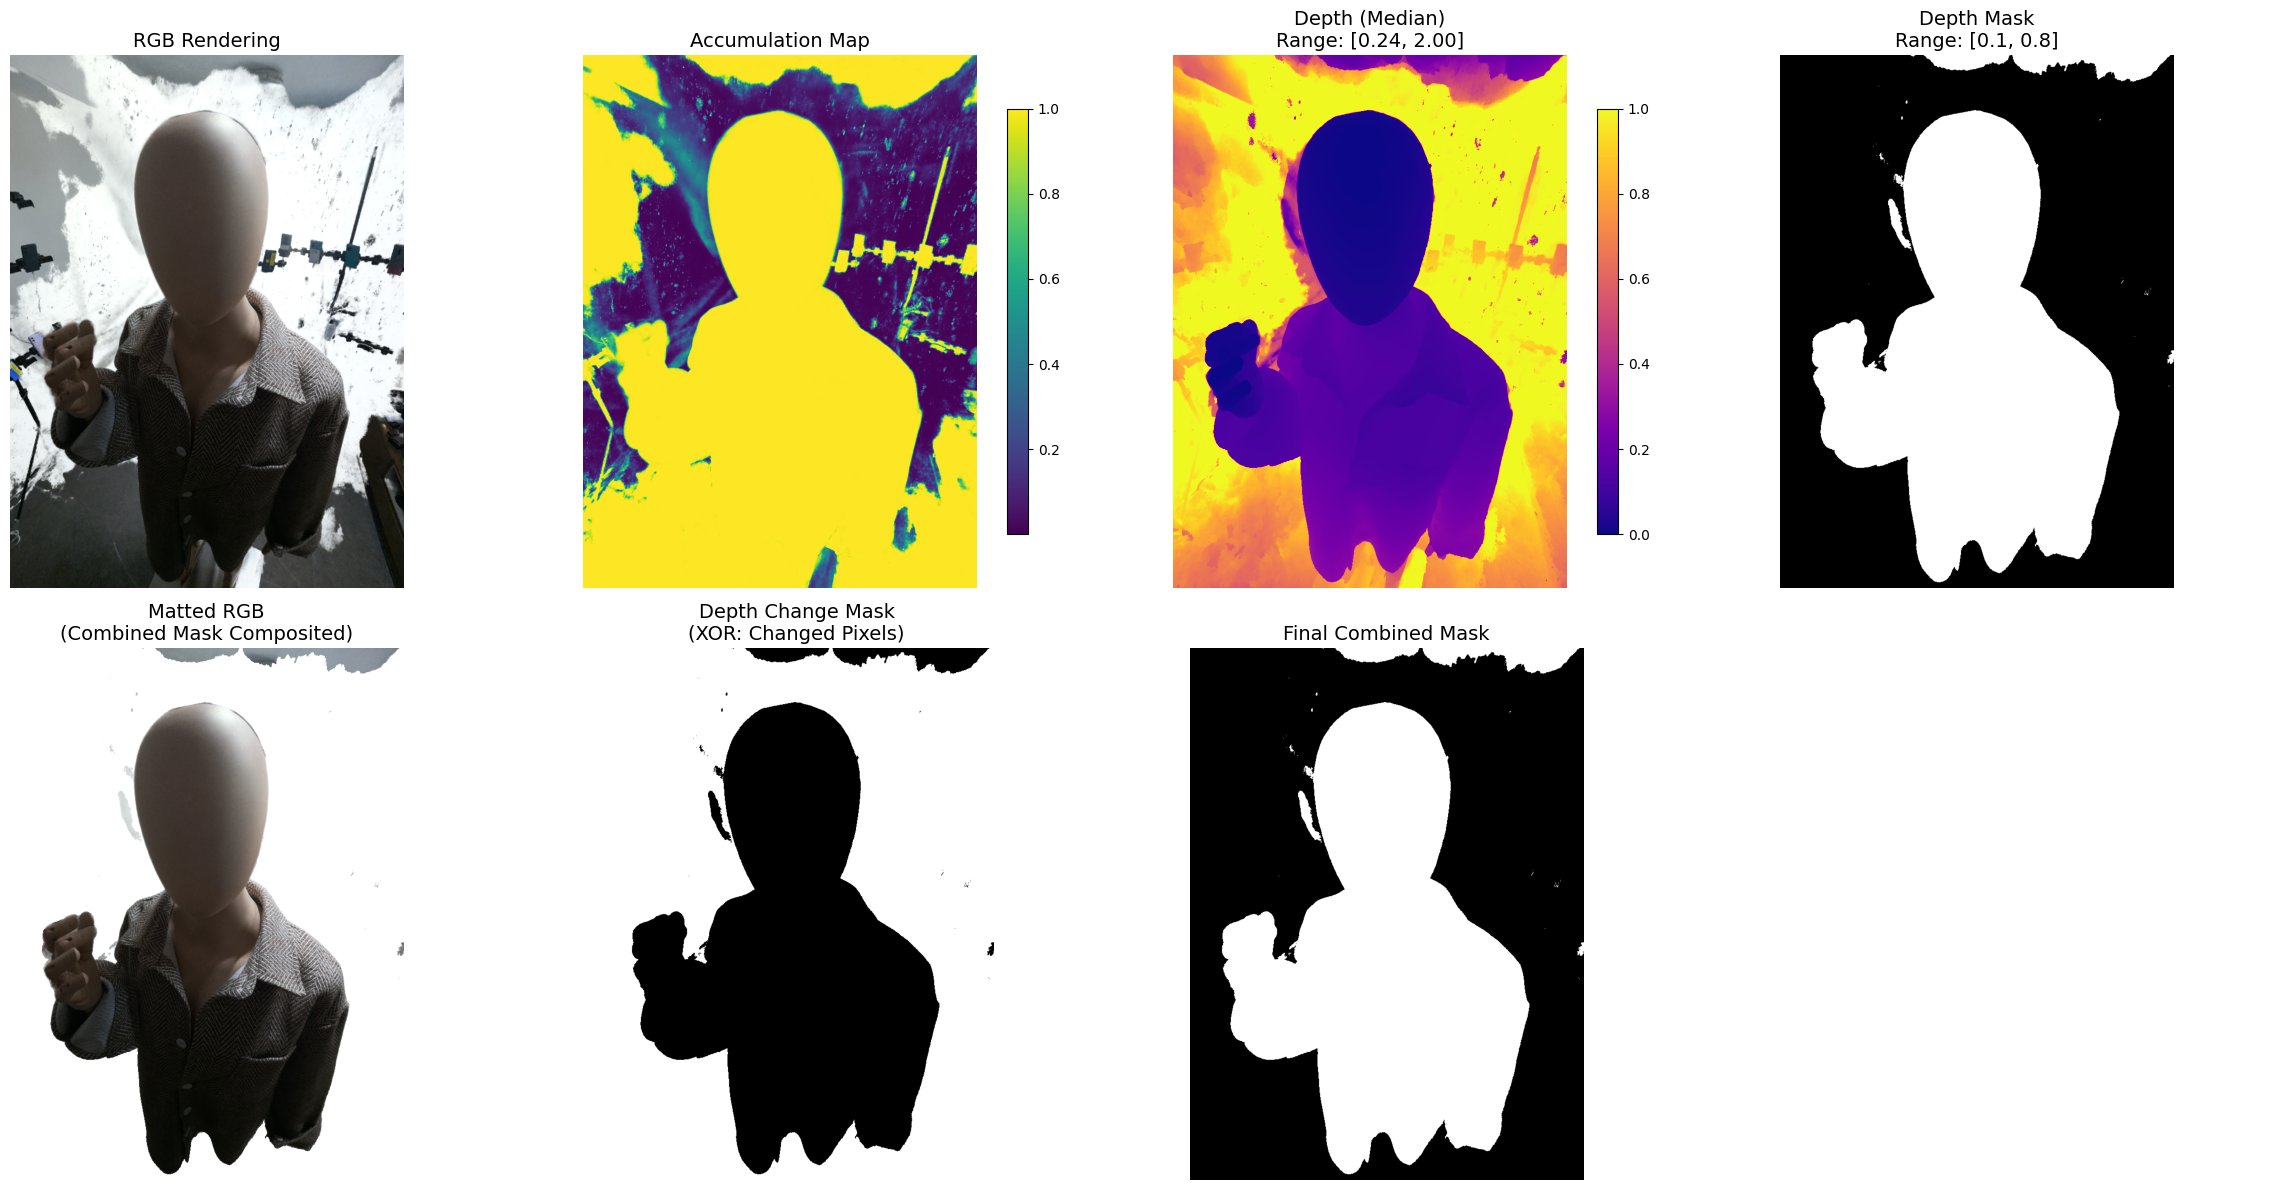

Thresholds used:
  Alpha minimum: 0.3
  Depth range: [0.1, 0.8]
  Pixels passing alpha threshold: 533370 / 763016 (69.9%)
  Pixels passing depth threshold: 309270 / 763016 (40.5%)
  Pixels in depth change mask (XOR): 453746 / 763016 (59.5%)
  Pixels in masked alpha: 309269 / 763016 (40.5%)
  Pixels in final combined mask: 309269 / 763016 (40.5%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_combined_mask(depth_original, acc_original, alpha_threshold, depth_min, depth_max):
    """
    Create a combined mask using XOR logic to identify changed depth pixels.
    
    Args:
        depth_original: Original depth map
        acc_original: Original accumulation map
        alpha_threshold: Minimum alpha/accumulation threshold
        depth_min: Minimum depth threshold
        depth_max: Maximum depth threshold
    
    Returns:
        combined_mask: Final combined mask
        alpha_mask: Alpha threshold mask
        depth_mask: Depth threshold mask
        depth_change_mask: XOR mask showing pixels that changed in depth
        masked_alpha: Alpha mask after removing changed depth pixels
    """
    
    # Step 1: Create alpha mask based on accumulation threshold
    alpha_mask = acc_original > alpha_threshold
    
    # Step 2: Create original depth mask (assuming all pixels were originally valid)
    # For this, we'll assume the original state is where depth > 0 or acc > 0
    original_depth_mask = (depth_original > 0) | (acc_original > 0)
    
    # Step 3: Create new depth mask based on depth thresholds
    new_depth_mask = (depth_original >= depth_min) & (depth_original <= depth_max)
    
    # Step 4: Create depth change mask using XOR
    # XOR shows pixels that are different between original and new masks
    depth_change_mask = original_depth_mask ^ new_depth_mask
    depth_change_mask = (depth_change_mask >= 1).astype(bool) # not working?
    
    # Step 5: Remove changed depth pixels from alpha mask
    # Only keep alpha pixels where depth hasn't changed
    masked_alpha = alpha_mask & ~depth_change_mask
    
    # Step 6: Final combined mask
    combined_mask = masked_alpha
    
    return combined_mask, alpha_mask, new_depth_mask, depth_change_mask, masked_alpha

# Test the function with your data
rgb = result["image"]
acc = result["acc"]
depth_median = result.get("depth_median", None)

print(f"RGB shape: {rgb.shape}")
print(f"Acc shape: {acc.shape}")
if depth_median is not None:
    print(f"Depth median shape: {depth_median.shape}")

# Thresholds for processing
ALPHA_MIN_THRESHOLD = 0.3  # Minimum alpha/accumulation threshold
DEPTH_MIN_THRESHOLD = 0.1  # Minimum depth threshold
DEPTH_MAX_THRESHOLD = 0.8  # Maximum depth threshold

# Use the new function to create combined mask
combined_mask, alpha_mask, depth_mask, depth_change_mask, masked_alpha = create_combined_mask(
    depth_median, acc, ALPHA_MIN_THRESHOLD, DEPTH_MIN_THRESHOLD, DEPTH_MAX_THRESHOLD
)

# Create matted RGB using the combined mask instead of original accumulation
rgb_matted = rgb.copy()
if len(rgb.shape) == 3:  # RGB image
    # Apply alpha matting using combined mask: result = foreground * alpha + background * (1 - alpha)
    # Using white background (1.0)
    for c in range(3):  # For each color channel
        rgb_matted[:, :, c] = rgb[:, :, c] * combined_mask + 1.0 * (1 - combined_mask)
else:
    rgb_matted = rgb * combined_mask + 1.0 * (1 - combined_mask)

# Convert images to uint8 for display
rgb_uint8 = (np.clip(rgb, 0, 1) * 255).astype(np.uint8)
rgb_matted_uint8 = (np.clip(rgb_matted, 0, 1) * 255).astype(np.uint8)
acc_uint8 = (np.clip(acc, 0, 1) * 255).astype(np.uint8)
alpha_mask_uint8 = (alpha_mask * 255).astype(np.uint8)

# Create subplot figure - now with 8 panels (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

# Row 1: Original outputs
# Display RGB image
axes[0, 0].imshow(rgb_uint8)
axes[0, 0].set_title('RGB Rendering', fontsize=14)
axes[0, 0].axis('off')

# Display accumulation map
im_acc = axes[0, 1].imshow(acc, cmap='viridis')
axes[0, 1].set_title('Accumulation Map', fontsize=14)
axes[0, 1].axis('off')
plt.colorbar(im_acc, ax=axes[0, 1], shrink=0.8)

# Normalize depth for better visualization
depth_normalized = (depth_median - depth_median.min()) / (depth_median.max() - depth_median.min() + 1e-8)
im_depth = axes[0, 2].imshow(depth_normalized, cmap='plasma')
axes[0, 2].set_title(f'Depth (Median)\nRange: [{depth_median.min():.2f}, {depth_median.max():.2f}]', fontsize=14)
axes[0, 2].axis('off')
plt.colorbar(im_depth, ax=axes[0, 2], shrink=0.8)

# Display alpha mask
axes[0, 3].imshow(alpha_mask, cmap='gray')
axes[0, 3].set_title(f'Alpha Mask\n(Threshold: {ALPHA_MIN_THRESHOLD})', fontsize=14)
axes[0, 3].axis('off')

# Display depth mask
axes[0, 3].imshow(depth_mask, cmap='gray')
axes[0, 3].set_title(f'Depth Mask\nRange: [{DEPTH_MIN_THRESHOLD}, {DEPTH_MAX_THRESHOLD}]', fontsize=14)
axes[0, 3].axis('off')

# Row 2: Processing steps and final result
# Display matted RGB
axes[1, 0].imshow(rgb_matted_uint8)
axes[1, 0].set_title('Matted RGB\n(Combined Mask Composited)', fontsize=14)
axes[1, 0].axis('off')

# Display depth change mask (XOR of original vs new depth mask)
axes[1, 1].imshow(depth_change_mask, cmap='gray')
axes[1, 1].set_title('Depth Change Mask\n(XOR: Changed Pixels)', fontsize=14)
axes[1, 1].axis('off')

# Display final combined mask
axes[1, 2].imshow(combined_mask, cmap='gray')
axes[1, 2].set_title('Final Combined Mask', fontsize=14)
axes[1, 2].axis('off')

# Keep one panel empty or add another visualization if needed
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Thresholds used:")
print(f"  Alpha minimum: {ALPHA_MIN_THRESHOLD}")
print(f"  Depth range: [{DEPTH_MIN_THRESHOLD}, {DEPTH_MAX_THRESHOLD}]")
print(f"  Pixels passing alpha threshold: {np.sum(alpha_mask)} / {alpha_mask.size} ({100*np.sum(alpha_mask)/alpha_mask.size:.1f}%)")
print(f"  Pixels passing depth threshold: {np.sum(depth_mask)} / {depth_mask.size} ({100*np.sum(depth_mask)/depth_mask.size:.1f}%)")
print(f"  Pixels in depth change mask (XOR): {np.sum(depth_change_mask)} / {depth_change_mask.size} ({100*np.sum(depth_change_mask)/depth_change_mask.size:.1f}%)")
print(f"  Pixels in masked alpha: {np.sum(masked_alpha)} / {masked_alpha.size} ({100*np.sum(masked_alpha)/masked_alpha.size:.1f}%)")
print(f"  Pixels in final combined mask: {np.sum(combined_mask)} / {combined_mask.size} ({100*np.sum(combined_mask)/combined_mask.size:.1f}%)")

In [46]:
# Save individual visualizations
print("Saving individual visualizations...")

# Save RGB image
rgb_path = os.path.join("exp/dump", "nerf_rgb.png")
Image.fromarray(rgb_uint8).save(rgb_path)

# Save matted RGB (now using combined mask)
rgb_matted_path = os.path.join("exp/dump", "nerf_rgb_matted.png")
Image.fromarray(rgb_matted_uint8).save(rgb_matted_path)

# Save accumulation map
acc_path = os.path.join("exp/dump", "nerf_acc.png")
plt.figure(figsize=(8, 6))
plt.imshow(acc, cmap='viridis')
plt.axis('off')
plt.savefig(acc_path, bbox_inches='tight', dpi=300, pad_inches=0)
plt.close()

# Save alpha mask
alpha_mask_path = os.path.join("exp/dump", "nerf_alpha_mask.png")
plt.figure(figsize=(8, 6))
plt.imshow(alpha_mask, cmap='gray')
plt.axis('off')
plt.savefig(alpha_mask_path, bbox_inches='tight', dpi=300, pad_inches=0)
plt.close()

# Save depth visualization
depth_path = os.path.join("exp/dump", "nerf_depth.png")
plt.figure(figsize=(8, 6))
depth_normalized = (depth_median - depth_median.min()) / (depth_median.max() - depth_median.min() + 1e-8)
plt.imshow(depth_normalized, cmap='gray')
plt.axis('off')
plt.savefig(depth_path, bbox_inches='tight', dpi=300, pad_inches=0)
plt.close()

# Save depth mask
depth_mask_path = os.path.join("exp/dump", "nerf_depth_mask.png")
plt.figure(figsize=(8, 6))
plt.imshow(depth_mask, cmap='gray')
plt.axis('off')
plt.savefig(depth_mask_path, bbox_inches='tight', dpi=300, pad_inches=0)
plt.close()

# Save depth change mask (XOR mask showing changed pixels)
depth_change_mask_path = os.path.join("exp/dump", "nerf_depth_change_mask.png")
plt.figure(figsize=(8, 6))
plt.imshow(depth_change_mask, cmap='gray')
plt.axis('off')
plt.savefig(depth_change_mask_path, bbox_inches='tight', dpi=300, pad_inches=0)
plt.close()

# Save combined mask
combined_mask_path = os.path.join("exp/dump", "nerf_combined_mask.png")
plt.figure(figsize=(8, 6))
plt.imshow(combined_mask, cmap='gray')
plt.axis('off')
plt.savefig(combined_mask_path, bbox_inches='tight', dpi=300, pad_inches=0)
plt.close()

print("All visualizations saved successfully!")
print(f"Files saved:")
print(f"  - {rgb_path}")
print(f"  - {rgb_matted_path}")
print(f"  - {acc_path}")
print(f"  - {alpha_mask_path}")
print(f"  - {depth_path}")
print(f"  - {depth_mask_path}")
print(f"  - {depth_change_mask_path}")
print(f"  - {combined_mask_path}")

Saving individual visualizations...
All visualizations saved successfully!
Files saved:
  - exp/dump/nerf_rgb.png
  - exp/dump/nerf_rgb_matted.png
  - exp/dump/nerf_acc.png
  - exp/dump/nerf_alpha_mask.png
  - exp/dump/nerf_depth.png
  - exp/dump/nerf_depth_mask.png
  - exp/dump/nerf_depth_change_mask.png
  - exp/dump/nerf_combined_mask.png
